In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

## Define FCN16s model for deconvolution layers

In [2]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [3]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [4]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [5]:
batch_size = 12
epochs     = 100  #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 5
gamma      = 0.5
model_use  = "unity" # "unity" "histogram" "box_gan"
n_class = 21

## Define path, directory trainning environment

In [6]:
# get data
data_dir  = os.path.join("/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN", model_use)
if not os.path.exists(data_dir):
    print("Data not found!")
# create dir for model
model_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/mm_fcn/models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/mm_fcn/scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 10.436078310012817


Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.



In [7]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w
brand_class = ['3m', 'andes', 'cocacola', 'crayola', 'folgers','heineken','hunts','kellogg','kleenex',\
               'kotex','libava','macadamia','milo','mm','pocky','raisins','stax','swissmiss','vanish','viva']
class product_dataset(Dataset):

    def __init__(self, csv_file, phase, n_class=n_class, flip_rate=0.):
        self.data      = pd.read_csv(csv_file)
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name   = self.data.iloc[idx, 0]
        img        = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
        label_name = self.data.iloc[idx, 1]
        label      = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
        origin_img = img
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        
        '''for i in range(n_class - 1):
            if brand_class[i] in img_name:
                target[i+1][label != 0] = 1
                label[label != 0] = i+1
                #print(brand_class[i], img_name,label_name)'''
        for i in range(n_class):
            target[i][label == i] = 1
        
        #target[0][label == 0] = 1
        #print(np.unique(label))
        
 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

## Define dataloader and optimizer

In [8]:
# initial dataloader for trainning and validation
train_file = os.path.join(data_dir, "train.csv")
val_file   = os.path.join(data_dir, "test.csv")
train_data = product_dataset(csv_file = train_file, phase = 'train')
val_data   = product_dataset(csv_file = val_file, phase = 'val', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 4, num_workers = 0)

dataiter = iter(val_loader)

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

## Train

In [9]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        scheduler.step()
        configs    = "FCNs_{}_batch{}_epoch{}_RMSprop_lr{}"\
            .format(model_use, batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch+1, iter, loss.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        if epoch % 1 == 0:
            torch.save(fcn_model.state_dict(),model_path + '.pkl')

        val(epoch)

## Evaluation

In [10]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [ ]:
train()

epoch1, iter0, loss: 0.6818637251853943
epoch1, iter10, loss: 0.6668141484260559
epoch1, iter20, loss: 0.6623030304908752
epoch1, iter30, loss: 0.6565538644790649
epoch1, iter40, loss: 0.653995156288147
epoch1, iter50, loss: 0.6524785161018372
epoch1, iter60, loss: 0.649207592010498
epoch1, iter70, loss: 0.6478565335273743
epoch1, iter80, loss: 0.6440058946609497
epoch1, iter90, loss: 0.6402646899223328
epoch1, iter100, loss: 0.6387847065925598
epoch1, iter110, loss: 0.6387487649917603
epoch1, iter120, loss: 0.6362878680229187
epoch1, iter130, loss: 0.6329440474510193
epoch1, iter140, loss: 0.6313982605934143
epoch1, iter150, loss: 0.6307145357131958
epoch1, iter160, loss: 0.6278716325759888
epoch1, iter170, loss: 0.6266862154006958
epoch1, iter180, loss: 0.620898425579071
epoch1, iter190, loss: 0.6229195594787598
epoch1, iter200, loss: 0.6199415922164917
epoch1, iter210, loss: 0.6173848509788513
epoch1, iter220, loss: 0.614616334438324
epoch1, iter230, loss: 0.6152704954147339
epoch1,

epoch1, iter1930, loss: 0.1661158949136734
epoch1, iter1940, loss: 0.1634850651025772
epoch1, iter1950, loss: 0.16184377670288086
epoch1, iter1960, loss: 0.161033034324646
epoch1, iter1970, loss: 0.15782469511032104
epoch1, iter1980, loss: 0.15556193888187408
epoch1, iter1990, loss: 0.1543305516242981
epoch1, iter2000, loss: 0.15053752064704895
epoch1, iter2010, loss: 0.1506326049566269
epoch1, iter2020, loss: 0.14937245845794678
epoch1, iter2030, loss: 0.14597931504249573
epoch1, iter2040, loss: 0.14454196393489838
epoch1, iter2050, loss: 0.14333227276802063
epoch1, iter2060, loss: 0.1403675675392151
epoch1, iter2070, loss: 0.13956904411315918
epoch1, iter2080, loss: 0.13888823986053467
epoch1, iter2090, loss: 0.1375715434551239
epoch1, iter2100, loss: 0.13450545072555542
epoch1, iter2110, loss: 0.1311795711517334
epoch1, iter2120, loss: 0.13115298748016357
epoch1, iter2130, loss: 0.1299537867307663
epoch1, iter2140, loss: 0.12778261303901672
epoch1, iter2150, loss: 0.1263549476861953

epoch1, iter3790, loss: 0.015584221109747887
epoch1, iter3800, loss: 0.014994694851338863
epoch1, iter3810, loss: 0.019859997555613518
epoch1, iter3820, loss: 0.013139227405190468
epoch1, iter3830, loss: 0.015239916741847992
epoch1, iter3840, loss: 0.019731080159544945
epoch1, iter3850, loss: 0.015926320105791092
epoch1, iter3860, loss: 0.015776343643665314
epoch1, iter3870, loss: 0.014548763632774353
epoch1, iter3880, loss: 0.013643587939441204
epoch1, iter3890, loss: 0.013924932107329369
epoch1, iter3900, loss: 0.012255937792360783
epoch1, iter3910, loss: 0.013418477959930897
epoch1, iter3920, loss: 0.013621109537780285
epoch1, iter3930, loss: 0.016216356307268143
epoch1, iter3940, loss: 0.01407663244754076
epoch1, iter3950, loss: 0.012112557888031006
epoch1, iter3960, loss: 0.015291277319192886
epoch1, iter3970, loss: 0.011287580244243145
epoch1, iter3980, loss: 0.011300129815936089
epoch1, iter3990, loss: 0.012448909692466259
epoch1, iter4000, loss: 0.011661854572594166
epoch1, ite

epoch2, iter240, loss: 0.0026312361005693674
epoch2, iter250, loss: 0.0030197936575859785
epoch2, iter260, loss: 0.0028495346195995808
epoch2, iter270, loss: 0.0029550022445619106
epoch2, iter280, loss: 0.0022625902201980352
epoch2, iter290, loss: 0.0021955424454063177
epoch2, iter300, loss: 0.0033190245740115643
epoch2, iter310, loss: 0.0029163742437958717
epoch2, iter320, loss: 0.003626118879765272
epoch2, iter330, loss: 0.0034428052604198456
epoch2, iter340, loss: 0.012020930647850037
epoch2, iter350, loss: 0.00993083231151104
epoch2, iter360, loss: 0.002396073192358017
epoch2, iter370, loss: 0.0022852278780192137
epoch2, iter380, loss: 0.002564667956903577
epoch2, iter390, loss: 0.003228535410016775
epoch2, iter400, loss: 0.0019183814292773604
epoch2, iter410, loss: 0.002825547941029072
epoch2, iter420, loss: 0.002883808221668005
epoch2, iter430, loss: 0.00207858020439744
epoch2, iter440, loss: 0.0028457166627049446
epoch2, iter450, loss: 0.0025610998272895813
epoch2, iter460, loss

epoch2, iter2060, loss: 0.002898962004110217
epoch2, iter2070, loss: 0.0009069778025150299
epoch2, iter2080, loss: 0.0009277922217734158
epoch2, iter2090, loss: 0.0010833046399056911
epoch2, iter2100, loss: 0.0008934753714129329
epoch2, iter2110, loss: 0.000714975583832711
epoch2, iter2120, loss: 0.001126923132687807
epoch2, iter2130, loss: 0.0005357001791708171
epoch2, iter2140, loss: 0.0005964876618236303
epoch2, iter2150, loss: 0.0006489030783995986
epoch2, iter2160, loss: 0.0011636129347607493
epoch2, iter2170, loss: 0.0005523376748897135
epoch2, iter2180, loss: 0.0005510682822205126
epoch2, iter2190, loss: 0.0005580087308771908
epoch2, iter2200, loss: 0.0006141411722637713
epoch2, iter2210, loss: 0.001300133648328483
epoch2, iter2220, loss: 0.0009006574982777238
epoch2, iter2230, loss: 0.0008210793603211641
epoch2, iter2240, loss: 0.000630910275503993
epoch2, iter2250, loss: 0.00048202500329352915
epoch2, iter2260, loss: 0.0014424686087295413
epoch2, iter2270, loss: 0.000923180195

epoch2, iter3850, loss: 0.0005021989927627146
epoch2, iter3860, loss: 0.0011596822878345847
epoch2, iter3870, loss: 0.004257424734532833
epoch2, iter3880, loss: 0.0020562761928886175
epoch2, iter3890, loss: 0.0007446967647410929
epoch2, iter3900, loss: 0.0004947164561599493
epoch2, iter3910, loss: 0.0008615173283033073
epoch2, iter3920, loss: 0.00036917338729836047
epoch2, iter3930, loss: 0.0004592347249854356
epoch2, iter3940, loss: 0.0005403461400419474
epoch2, iter3950, loss: 0.0007011595880612731
epoch2, iter3960, loss: 0.0003890389343723655
epoch2, iter3970, loss: 0.0008116360986605287
epoch2, iter3980, loss: 0.00044256230466999114
epoch2, iter3990, loss: 0.0004841714689973742
epoch2, iter4000, loss: 0.0005429324228316545
epoch2, iter4010, loss: 0.0005218869191594422
epoch2, iter4020, loss: 0.0015395254595205188
epoch2, iter4030, loss: 0.0020105044823139906
epoch2, iter4040, loss: 0.0007199989049695432
epoch2, iter4050, loss: 0.0011536988895386457
epoch2, iter4060, loss: 0.0004334

epoch3, iter260, loss: 0.00042581185698509216
epoch3, iter270, loss: 0.000519620138220489
epoch3, iter280, loss: 0.00043400583672337234
epoch3, iter290, loss: 0.0002847363939508796
epoch3, iter300, loss: 0.0003379091795068234
epoch3, iter310, loss: 0.01050426997244358
epoch3, iter320, loss: 0.00045077846152707934
epoch3, iter330, loss: 0.0006600726628676057
epoch3, iter340, loss: 0.0019021565094590187
epoch3, iter350, loss: 0.0020420013461261988
epoch3, iter360, loss: 0.00039215796277858317
epoch3, iter370, loss: 0.0005529881455004215
epoch3, iter380, loss: 0.0003802698338404298
epoch3, iter390, loss: 0.0003204867825843394
epoch3, iter400, loss: 0.000399844313506037
epoch3, iter410, loss: 0.00041423601214773953
epoch3, iter420, loss: 0.0003635388857219368
epoch3, iter430, loss: 0.0004789980303030461
epoch3, iter440, loss: 0.00030282337684184313
epoch3, iter450, loss: 0.00038736863643862307
epoch3, iter460, loss: 0.00363990874029696
epoch3, iter470, loss: 0.0009536469005979598
epoch3, i

epoch3, iter2050, loss: 0.0004047089605592191
epoch3, iter2060, loss: 0.000740124611184001
epoch3, iter2070, loss: 0.0003182771906722337
epoch3, iter2080, loss: 0.0008168975473381579
epoch3, iter2090, loss: 0.0003282650432083756
epoch3, iter2100, loss: 0.000292370212264359
epoch3, iter2110, loss: 0.00043993251165375113
epoch3, iter2120, loss: 0.00029731259564869106
epoch3, iter2130, loss: 0.00028236713842488825
epoch3, iter2140, loss: 0.00029723087209276855
epoch3, iter2150, loss: 0.00028501919587142766
epoch3, iter2160, loss: 0.0004018036415800452
epoch3, iter2170, loss: 0.00026378585607744753
epoch3, iter2180, loss: 0.00024874869268387556
epoch3, iter2190, loss: 0.00036044197622686625
epoch3, iter2200, loss: 0.03411092236638069
epoch3, iter2210, loss: 0.00323875667527318
epoch3, iter2220, loss: 0.0010444673243910074
epoch3, iter2230, loss: 0.00044301856542006135
epoch3, iter2240, loss: 0.0006923372857272625
epoch3, iter2250, loss: 0.0006450610235333443
epoch3, iter2260, loss: 0.00035

epoch3, iter3830, loss: 0.000477066554594785
epoch3, iter3840, loss: 0.00033360556699335575
epoch3, iter3850, loss: 0.0005521559505723417
epoch3, iter3860, loss: 0.00034438876900821924
epoch3, iter3870, loss: 0.00024372964981012046
epoch3, iter3880, loss: 0.0003896703419741243
epoch3, iter3890, loss: 0.00021589125390164554
epoch3, iter3900, loss: 0.0002888168965000659
epoch3, iter3910, loss: 0.0016572460299357772
epoch3, iter3920, loss: 0.0003128700191155076
epoch3, iter3930, loss: 0.00025923573412001133
epoch3, iter3940, loss: 0.00041121465619653463
epoch3, iter3950, loss: 0.00022258845274336636
epoch3, iter3960, loss: 0.00029849965358152986
epoch3, iter3970, loss: 0.0002742226351983845
epoch3, iter3980, loss: 0.00035224290331825614
epoch3, iter3990, loss: 0.0004525861004367471
epoch3, iter4000, loss: 0.00026994437212124467
epoch3, iter4010, loss: 0.00028115647728554904
epoch3, iter4020, loss: 0.014762990176677704
epoch3, iter4030, loss: 0.001520701451227069
epoch3, iter4040, loss: 0.

epoch4, iter240, loss: 0.0006758762756362557
epoch4, iter250, loss: 0.00024306512204930186
epoch4, iter260, loss: 0.0003318152448628098
epoch4, iter270, loss: 0.000299306761007756
epoch4, iter280, loss: 0.0002876257640309632
epoch4, iter290, loss: 0.00022544917010236531
epoch4, iter300, loss: 0.0002648111549206078
epoch4, iter310, loss: 0.0004145303973928094
epoch4, iter320, loss: 0.00022269583132583648
epoch4, iter330, loss: 0.0002664804342202842
epoch4, iter340, loss: 0.00023031381715554744
epoch4, iter350, loss: 0.0003056528512388468
epoch4, iter360, loss: 0.00026912218891084194
epoch4, iter370, loss: 0.019382482394576073
epoch4, iter380, loss: 0.0008816855261102319
epoch4, iter390, loss: 0.00046970543917268515
epoch4, iter400, loss: 0.0002574232348706573
epoch4, iter410, loss: 0.0012988311937078834
epoch4, iter420, loss: 0.0002275282022310421
epoch4, iter430, loss: 0.0005126332398504019
epoch4, iter440, loss: 0.0003111903788521886
epoch4, iter450, loss: 0.00027201412012800574
epoch

epoch4, iter2030, loss: 0.00040623656241223216
epoch4, iter2040, loss: 0.00026133505161851645
epoch4, iter2050, loss: 0.000613430340308696
epoch4, iter2060, loss: 0.00023584297741763294
epoch4, iter2070, loss: 0.00027736640186049044
epoch4, iter2080, loss: 0.00023857192718423903
epoch4, iter2090, loss: 0.00025673635536804795
epoch4, iter2100, loss: 0.011723323725163937
epoch4, iter2110, loss: 0.0014502626145258546
epoch4, iter2120, loss: 0.00043993370491079986
epoch4, iter2130, loss: 0.000306589063256979
epoch4, iter2140, loss: 0.00024552884860895574
epoch4, iter2150, loss: 0.00028473397833295166
epoch4, iter2160, loss: 0.0002554343082010746
epoch4, iter2170, loss: 0.0002363607636652887
epoch4, iter2180, loss: 0.00034933682763949037
epoch4, iter2190, loss: 0.00030249127303250134
epoch4, iter2200, loss: 0.000231266938499175
epoch4, iter2210, loss: 0.00024286315601784736
epoch4, iter2220, loss: 0.00023750471882522106
epoch4, iter2230, loss: 0.0002671068359632045
epoch4, iter2240, loss: 0

epoch4, iter3800, loss: 0.0006176105234771967
epoch4, iter3810, loss: 0.00039189684321172535
epoch4, iter3820, loss: 0.0004223839787300676
epoch4, iter3830, loss: 0.00023858439817558974
epoch4, iter3840, loss: 0.0006578238680958748
epoch4, iter3850, loss: 0.0003791848139371723
epoch4, iter3860, loss: 0.0004856071900576353
epoch4, iter3870, loss: 0.00029168371111154556
epoch4, iter3880, loss: 0.0001804492640076205
epoch4, iter3890, loss: 0.00028425990603864193
epoch4, iter3900, loss: 0.00043806308531202376
epoch4, iter3910, loss: 0.00026048143627122045
epoch4, iter3920, loss: 0.00021608744282275438
epoch4, iter3930, loss: 0.0002203729236498475
epoch4, iter3940, loss: 0.00019415642600506544
epoch4, iter3950, loss: 0.0002447845763526857
epoch4, iter3960, loss: 0.0002428496372886002
epoch4, iter3970, loss: 0.0002497914247214794
epoch4, iter3980, loss: 0.0035224666353315115
epoch4, iter3990, loss: 0.0006343793356791139
epoch4, iter4000, loss: 0.00029334198916330934
epoch4, iter4010, loss: 0

## Prediction Result 

In [15]:
def prediction(model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin'] 
    label  = batch['l']
    
    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

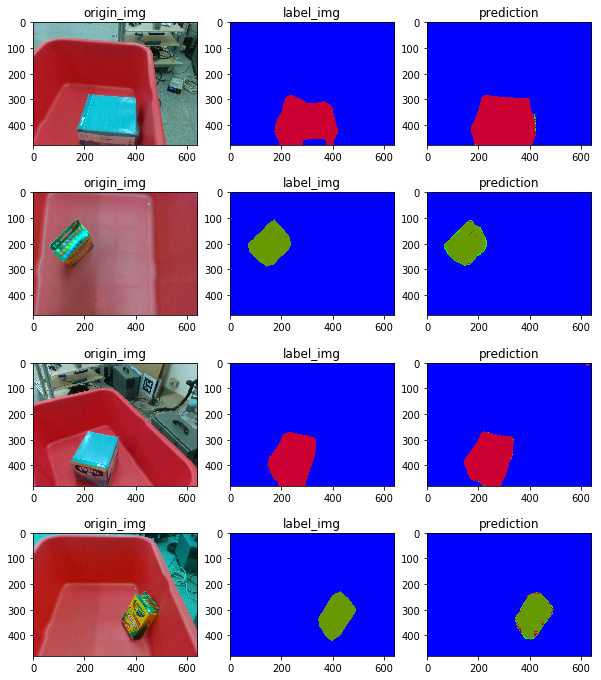

In [16]:
prediction("FCNs_products_20_batch10_epoch0_RMSprop_lr0.0001.pkl")